In [8]:
import torch
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from google.colab import drive

drive.mount('/content/drive')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cpu


In [9]:
def get_robust_resnet18():
    model = models.resnet18(weights=None)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(512, 10)
    return model.to(device)

def get_robust_resnet50():
    model = models.resnet50(weights=None)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(2048, 10)
    return model.to(device)

In [10]:
print("Loading Robust Models...")

model_18 = get_robust_resnet18()
model_18.load_state_dict(torch.load('/content/drive/My Drive/adversarial_mnist/saved_models/resnet18_pgd_robust.pth', map_location=device))
model_18.eval()

model_50 = get_robust_resnet50()
model_50.load_state_dict(torch.load('/content/drive/My Drive/adversarial_mnist/saved_models/resnet50_adv_robust.pth', map_location=device))
model_50.eval()
print("Models loaded successfully.")

Loading Robust Models...
Models loaded successfully.


In [11]:
print("Loading Adversarial Examples...")

examples_from_18 = torch.load('/content/drive/My Drive/adversarial_mnist/adversarial_examples/all_fooling_examples.pth', map_location=device)

examples_from_50 = torch.load('/content/drive/My Drive/adversarial_mnist/adversarial_examples/all_fooling_examples_resnet50.pth', map_location=device)

print("Adversarial examples loaded.")

Loading Adversarial Examples...
Adversarial examples loaded.


In [12]:
def get_accuracy(model, data_bundle):
    images = data_bundle['adversarial_examples'].to(device)
    labels = torch.tensor(data_bundle['true_labels']).to(device)

    with torch.no_grad():
        logits = model(images)
        preds = logits.argmax(dim=1)
        correct = (preds == labels).sum().item()

    return (correct / len(labels)) * 100

print("Running Cross-Evaluation...")

acc_18_on_18 = get_accuracy(model_18, examples_from_18)

acc_50_on_18 = get_accuracy(model_50, examples_from_18)

acc_50_on_50 = get_accuracy(model_50, examples_from_50)

acc_18_on_50 = get_accuracy(model_18, examples_from_50)

print("Evaluation complete.")

Running Cross-Evaluation...
Evaluation complete.


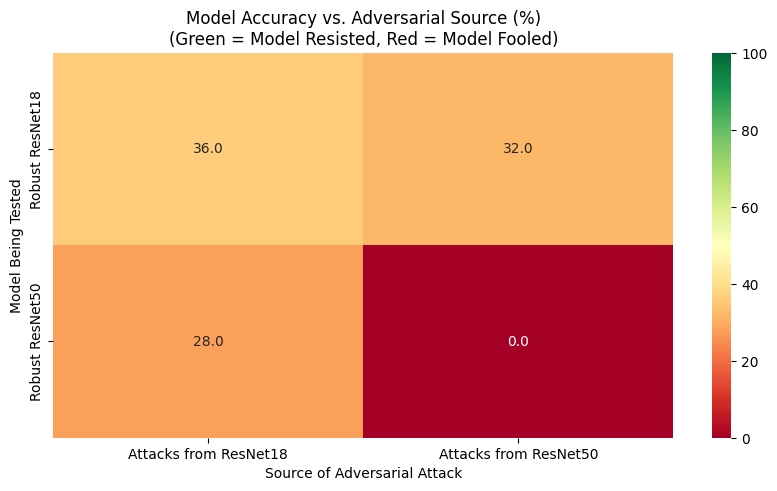

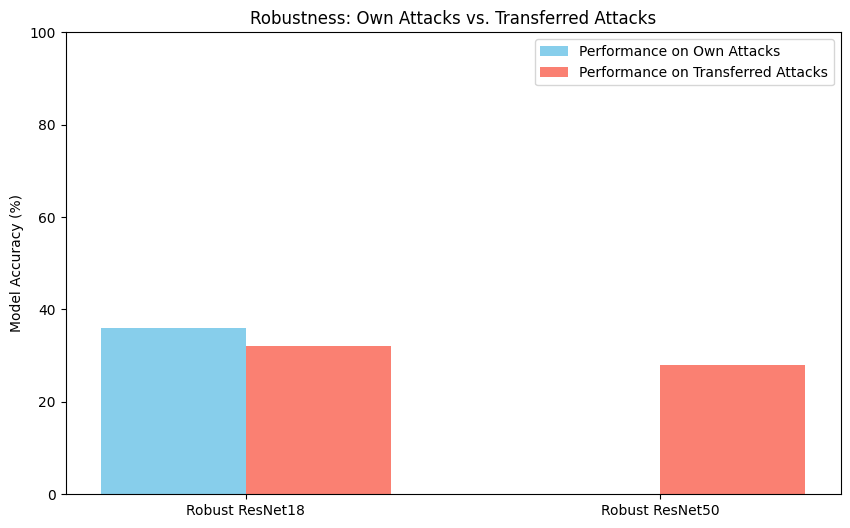


Results Summary:
1. Robust ResNet18 Accuracy on Own Attacks: 36.00%
2. Robust ResNet50 Accuracy on Own Attacks: 0.00%
3. Transfer 18->50 (Does 50 resist 18's attacks?): 28.00%
4. Transfer 50->18 (Does 18 resist 50's attacks?): 32.00%


In [13]:
matrix_data = np.array([
    [acc_18_on_18, acc_18_on_50],
    [acc_50_on_18, acc_50_on_50]
])

labels = ['Attacks from ResNet18', 'Attacks from ResNet50']
models_evaluated = ['Robust ResNet18', 'Robust ResNet50']

plt.figure(figsize=(10, 5))
sns.heatmap(matrix_data, annot=True, fmt=".1f", cmap="RdYlGn",
            xticklabels=labels, yticklabels=models_evaluated, vmin=0, vmax=100)
plt.title('Model Accuracy vs. Adversarial Source (%)\n(Green = Model Resisted, Red = Model Fooled)')
plt.xlabel('Source of Adversarial Attack')
plt.ylabel('Model Being Tested')
plt.show()

plt.figure(figsize=(10, 6))
x = np.arange(len(models_evaluated))
width = 0.35

own_scores = [acc_18_on_18, acc_50_on_50]
transfer_scores = [acc_18_on_50, acc_50_on_18]

plt.bar(x - width/2, own_scores, width, label='Performance on Own Attacks', color='skyblue')
plt.bar(x + width/2, transfer_scores, width, label='Performance on Transferred Attacks', color='salmon')

plt.ylabel('Model Accuracy (%)')
plt.title('Robustness: Own Attacks vs. Transferred Attacks')
plt.xticks(x, models_evaluated)
plt.legend()
plt.ylim(0, 100)
plt.show()

print(f"\nResults Summary:")
print(f"1. Robust ResNet18 Accuracy on Own Attacks: {acc_18_on_18:.2f}%")
print(f"2. Robust ResNet50 Accuracy on Own Attacks: {acc_50_on_50:.2f}%")
print(f"3. Transfer 18->50 (Does 50 resist 18's attacks?): {acc_50_on_18:.2f}%")
print(f"4. Transfer 50->18 (Does 18 resist 50's attacks?): {acc_18_on_50:.2f}%")